In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

blobs = pd.read_csv('kmeans_blobs.csv')
colnames = list(blobs.columns[1:-1])
blobs.head()

,ID,x,y,cluster
0,0,24.412,32.932,2
1,1,35.190,12.189,1
2,2,26.288,41.718,2
3,3,0.376,15.506,0
4,4,26.116,3.963,1


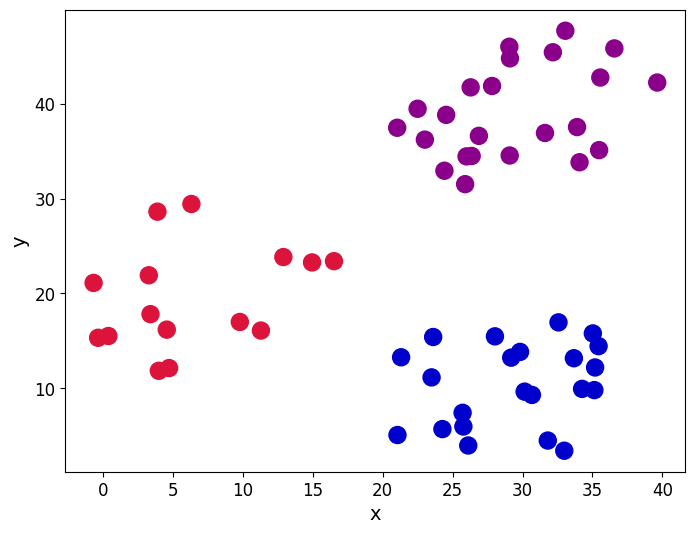

In [2]:
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x=blobs['x'], y=blobs['y'], s=150,
            c=blobs['cluster'].astype('category'), 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [3]:
def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

np.random.seed(42)
k=3
df = blobs[['x','y']]
centroids = initiate_centroids(k, df)
centroids

,x,y
0,24.412,32.932
5,25.893,31.515
36,26.878,36.609


In [4]:
def rsserr(a,b):
    '''
    Calculate the root of sum of squared errors. 
    a and b are numpy arrays
    '''
    return np.square(np.sum((a-b)**2)) 

In [5]:
for i, centroid in enumerate(range(centroids.shape[0])):
    err = rsserr(centroids.iloc[centroid,:], df.iloc[36,:])
    print('Error for centroid {0}: {1:.2f}'.format(i, err))

Error for centroid 0: 384.22
Error for centroid 1: 724.64
Error for centroid 2: 0.00


In [6]:
def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

In [7]:
df['centroid'], df['error'] = centroid_assignation(df, centroids)
df.head()

C:\Users\Gourab\AppData\Local\Temp\ipykernel_15592\3199595029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['centroid'], df['error'] = centroid_assignation(df, centroids)


,x,y,centroid,error
0,24.412,32.932,0,0.000000
1,35.190,12.189,1,211534.211314
2,26.288,41.718,2,699.601495
3,0.376,15.506,0,776856.744109
4,26.116,3.963,1,576327.599678


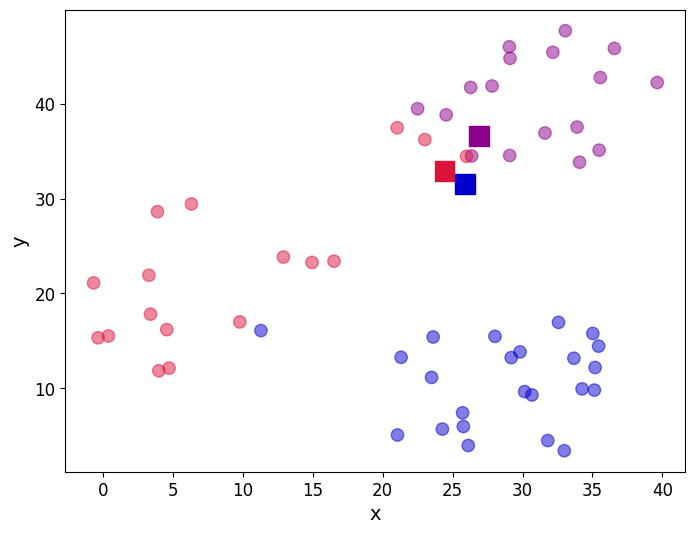

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [9]:
print("The total error is {0:.2f}".format(df['error'].sum()))

The total error is 11927659.01


In [10]:
centroids = df.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
centroids

,x,y
0,9.889444,23.242611
1,28.435750,11.546250
2,30.759333,40.311167


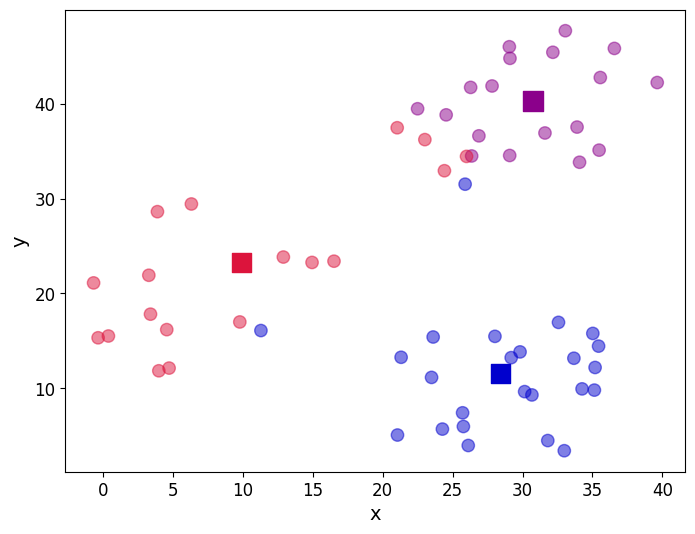

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200,
            c=[0, 1, 2], cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [12]:
def kmeans(dset, k=2, tol=1e-4):
    '''
    K-means implementationd for a 
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    '''
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the 
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0
    
    # Step 2: Initiate clusters by defining centroids 
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # Step 5 - Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Step 6 - Restart the iteration
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids

In [13]:
np.random.seed(42)
df['centroid'], df['error'], centroids =  kmeans(df[['x','y']], 3)
df.head()

,x,y,centroid,error
0,24.412,32.932,2,3767.568743
1,35.190,12.189,1,1399.889001
2,26.288,41.718,2,262.961097
3,0.376,15.506,0,2683.086425
4,26.116,3.963,1,2723.650198


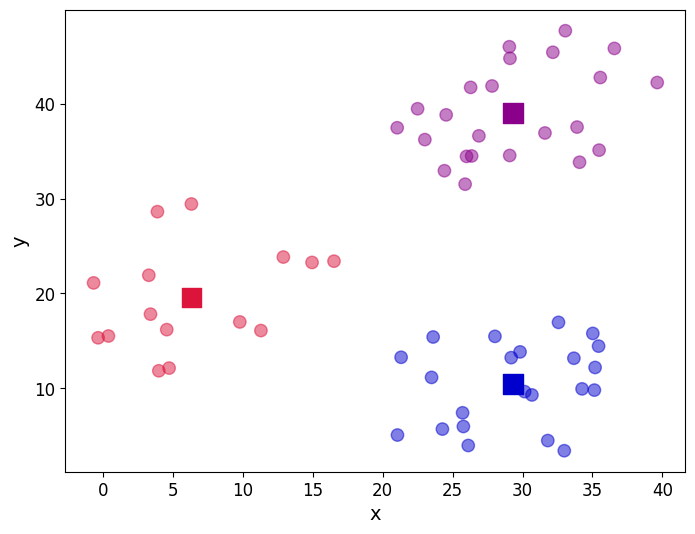

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

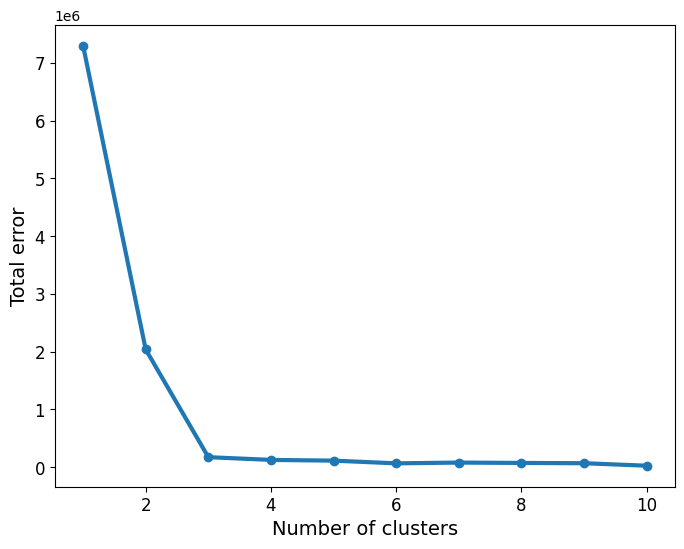

In [17]:
err_total = []
n = 10

df_elbow = blobs[['x','y']]

for i in range(n):
    _, my_errs, _ = kmeans(df_elbow, i+1)
    err_total.append(sum(my_errs))
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,n+1), err_total, linewidth=3, marker='o')
ax.set_xlabel(r'Number of clusters', fontsize=14)
ax.set_ylabel(r'Total error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [18]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle

# import some data to play with
iris = datasets.load_iris()
X = iris.data 
y = iris.target
names = iris.feature_names
X, y = shuffle(X, y, random_state=42)

In [19]:
model = KMeans(n_clusters=3, random_state=42) 
iris_kmeans = model.fit(X)

C:\Users\Gourab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
iris_kmeans.labels_

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1,
       1, 1, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2])

In [21]:
y = np.choose(y, [1, 2, 0]).astype(int)
y

array([2, 1, 0, 2, 2, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 2, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 0, 2, 2, 1,
       1, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1,
       2, 0, 1, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1,
       1, 2, 2, 0, 2, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 2,
       2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 0, 0, 1, 2, 0, 0,
       1, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 0, 1, 2, 0])

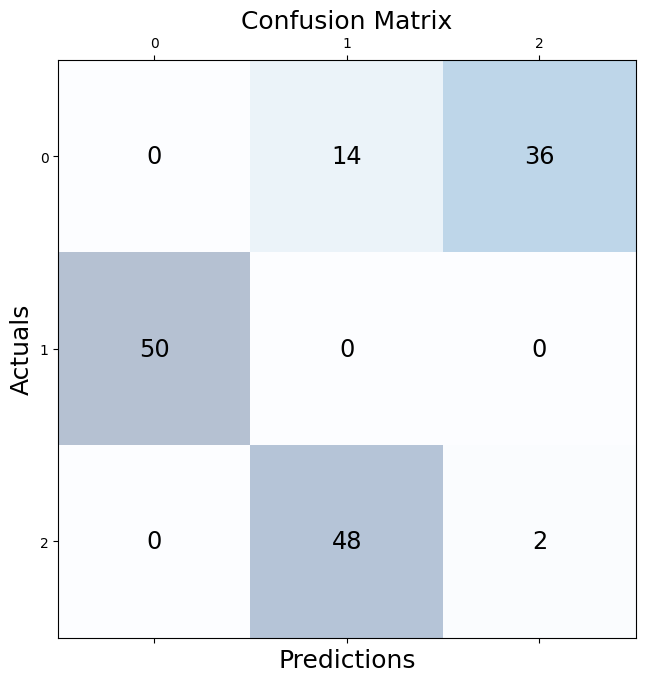

In [22]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y, iris_kmeans.labels_) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
                ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [23]:
iris_kmeans.cluster_centers_

array([[5.006     , 3.428     , 1.462     , 0.246     ],
       [5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
       [6.85      , 3.07368421, 5.74210526, 2.07105263]])

C:\Users\Gourab\AppData\Local\Temp\ipykernel_15592\1664843220.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


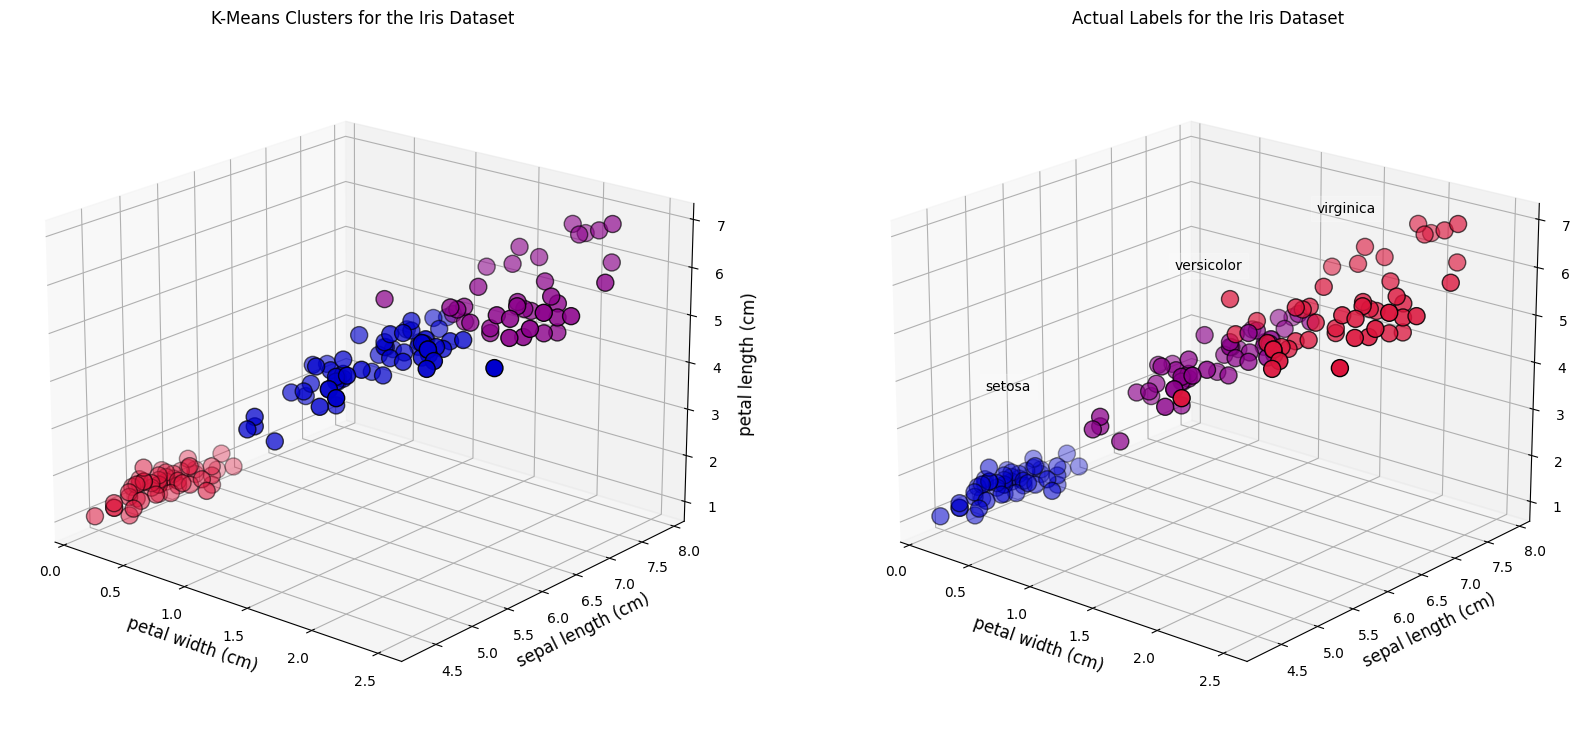

In [25]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X[:, 3], X[:, 0], X[:, 2], 
            c=iris_kmeans.labels_.astype(float), 
           edgecolor="k", s=150, cmap=customcmap)
ax1.view_init(20, -50)
ax1.set_xlabel(names[3], fontsize=12)
ax1.set_ylabel(names[0], fontsize=12)
ax1.set_zlabel(names[2], fontsize=12)
ax1.set_title("K-Means Clusters for the Iris Dataset", fontsize=12)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

for label, name in enumerate(['virginica','setosa','versicolor']):
    ax2.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )

ax2.scatter(X[:, 3], X[:, 0], X[:, 2], 
            c=y, edgecolor="k", s=150, 
            cmap=customcmap)
ax2.view_init(20, -50)
ax2.set_xlabel(names[3], fontsize=12)
ax2.set_ylabel(names[0], fontsize=12)
ax2.set_zlabel(names[2], fontsize=12)
ax2.set_title("Actual Labels for the Iris Dataset", fontsize=12)
fig.show()